In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import cartopy as cart

from glob import glob
import tqdm

import gsw

# set retina
%config InlineBackend.figure_format = 'retina'

In [2]:
data_dir = "/nethome/4302001/local_data/"
output_dir = "/nethome/4302001/NASTMW_DIC/analysis/output/"

In [3]:
hgrid = xr.open_dataset(data_dir + "mesh/mesh_hgr_PSY4V2_deg_NA_subset.nc")
zgrid = xr.open_dataset(data_dir + "mesh/mesh_zgr_PSY4V2_deg_NA_subset.nc")

In [4]:
t0 = np.datetime64('1992-01-01')
# tend = np.datetime64('2019-12-01')
tend = np.datetime64('1992-01-05')
t_length = tend-t0

In [5]:
timestamps = np.arange(t0, tend, np.timedelta64(1, 'D'), dtype='datetime64[D]')

In [6]:
ndays = t_length.astype('timedelta64[D]').astype(int)
nlevels = 75

In [7]:
EDW_files = sorted(glob(data_dir + "FREEGLORYS2V4_EDW/*EDW.nc"))
DIC_files = sorted(glob(data_dir + "FREEBIORYS2V4/*dic*.nc"))
T_files = sorted(glob(data_dir + "FREEGLORYS2V4/*_T_*.nc"))
S_files = sorted(glob(data_dir + "FREEGLORYS2V4/*_S_*.nc"))

In [8]:
DIC_record_gravimetric = np.zeros((ndays, nlevels)) * np.nan
DIC_record_volumetric = np.zeros((ndays, nlevels)) * np.nan    
DIC_record_carbon_mass = np.zeros(ndays) * np.nan

In [10]:
print("Station 1")
print(f"Lon : {float(dummy_dic.dic.isel(x=140, y=137).nav_lon.values):.3f}")
print(f"Lat : {float(dummy_dic.dic.isel(x=140, y=137).nav_lat.values):.3f}")

Station 1
Lon : -64.774
Lat : 32.698


In [11]:
print("Station 2")
print(f"Lon : {float(dummy_dic.dic.isel(x=199, y=136).nav_lon.values):.3f}")
print(f"Lat : {float(dummy_dic.dic.isel(x=199, y=136).nav_lat.values):.3f}")

Station 2
Lon : -50.018
Lat : 32.566


In [12]:
volume = (hgrid.e1t * hgrid.e2t * zgrid.e3t_1d).rename({"z":"deptht"}).assign_coords(deptht=dummy_dic.deptht)
areas = (hgrid.e1t * hgrid.e2t)

In [16]:
ds_DIC_record = xr.open_dataset("output/DIC_EDW_record.nc").isel(time=slice(365*3 + 1, -365*3+31))

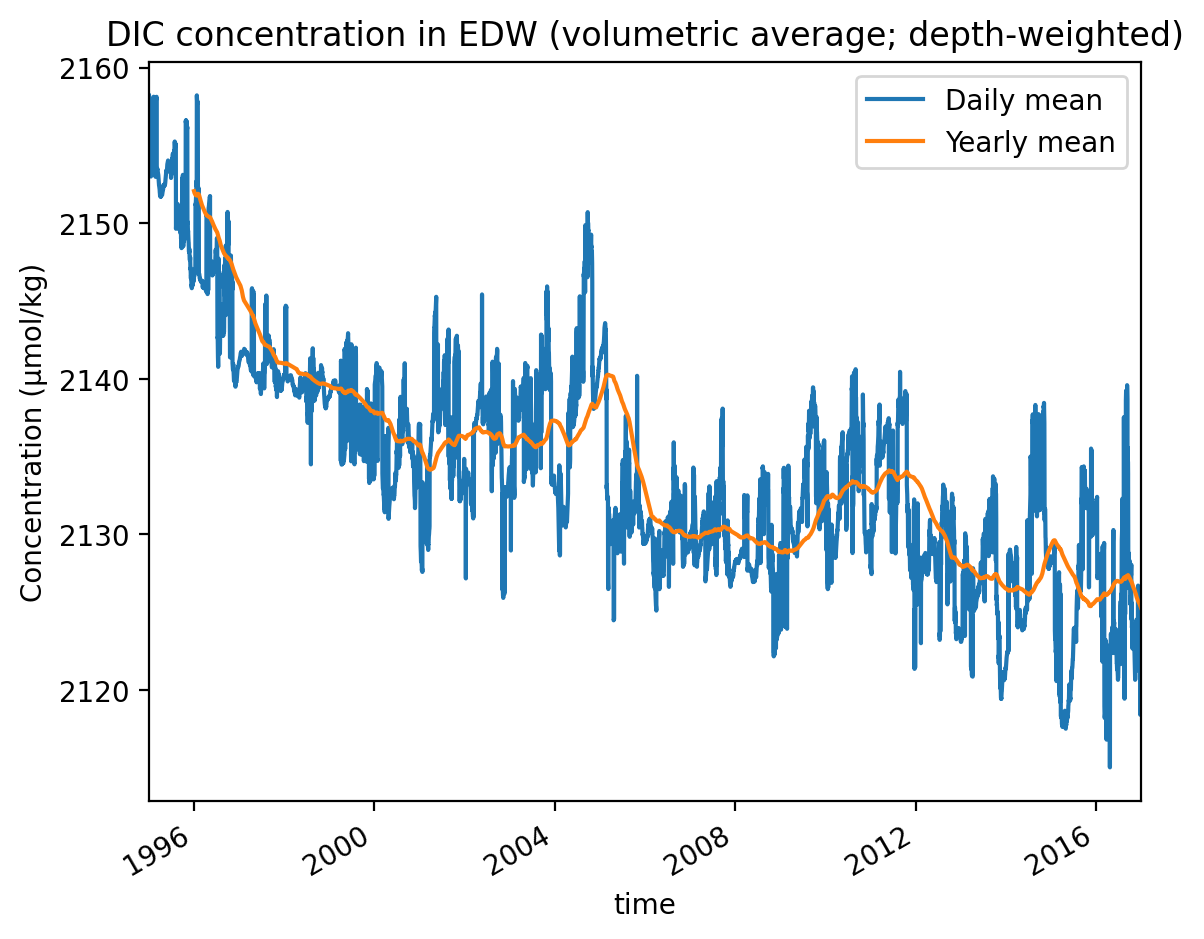

In [17]:
fig, ax = plt.subplots()
ds_DIC_record.weighted(ds_DIC_record.cell_thickness).mean(dim="deptht").DIC_EDW_volumetric.plot(label="Daily mean")
ax.set_xlim([ds_DIC_record.time[0], ds_DIC_record.time[-1]])
ds_DIC_record.weighted(ds_DIC_record.cell_thickness).mean(dim="deptht").DIC_EDW_volumetric.rolling(time=365).mean('time').plot(label="Yearly mean")
ax.set_ylabel("Concentration (µmol/kg)")
ax.title.set_text("DIC concentration in EDW (volumetric average; depth-weighted)")
plt.legend()


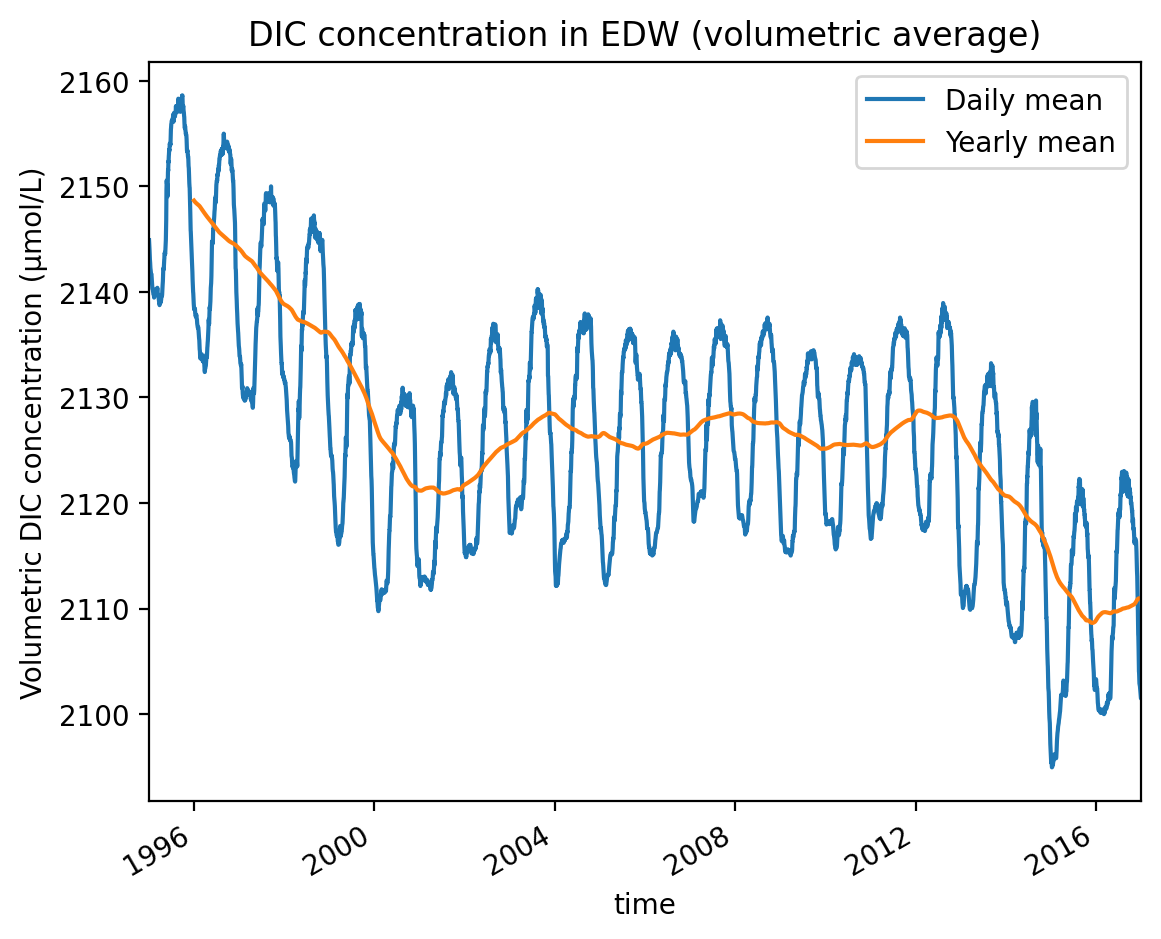

In [18]:


fig, ax = plt.subplots()
ds_DIC_record.DIC_EDW_volumetric_avg.plot(label="Daily mean")
ax.set_xlim([ds_DIC_record.time[0], ds_DIC_record.time[-1]])
ds_DIC_record.DIC_EDW_volumetric_avg.rolling(time=365).mean('time').plot(label="Yearly mean")
ax.set_ylabel("Volumetric DIC concentration (µmol/L)")
ax.title.set_text("DIC concentration in EDW (volumetric average)")

plt.legend()


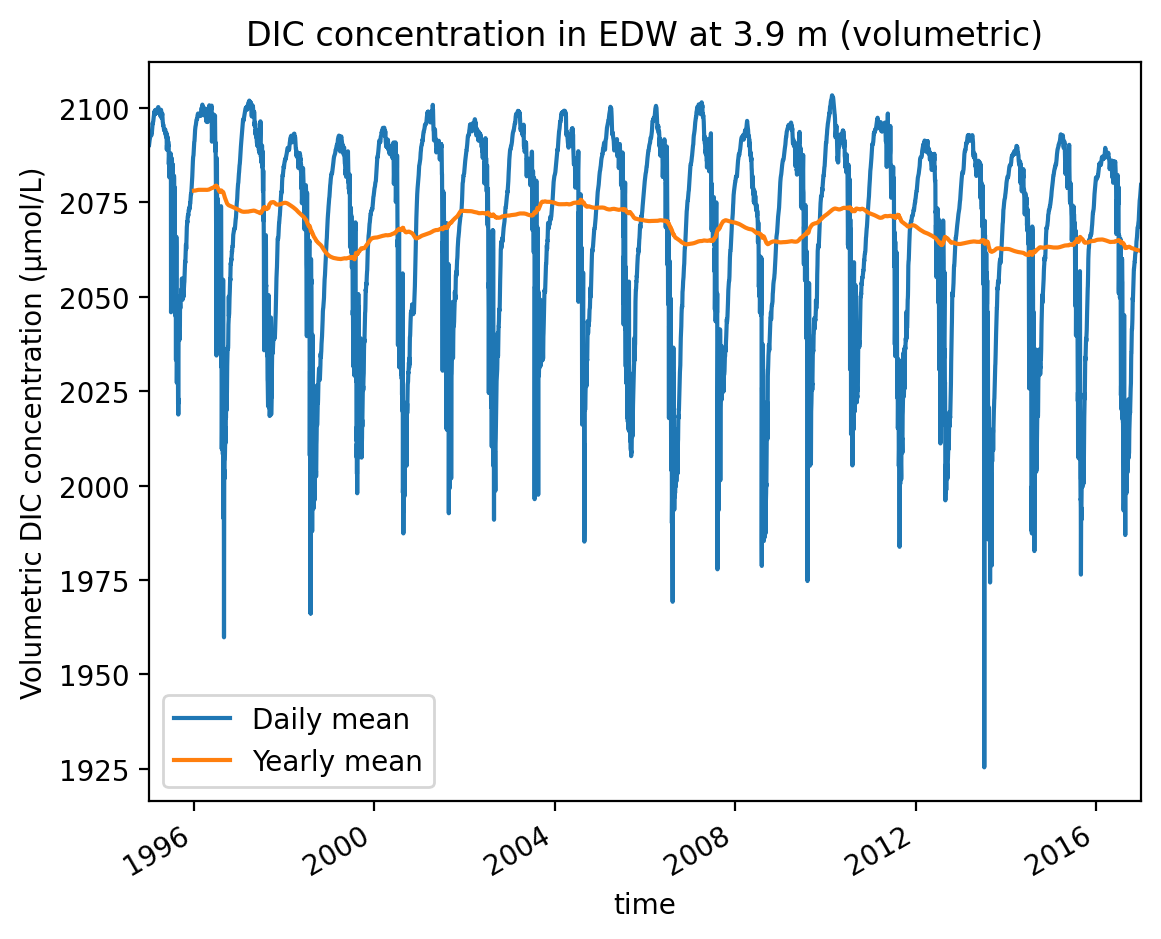

In [19]:
fig, ax = plt.subplots()
ds_DIC_record.isel(deptht=3).DIC_EDW_volumetric.plot(label="Daily mean")
ax.set_xlim([ds_DIC_record.time[0], ds_DIC_record.time[-1]])
ds_DIC_record.isel(deptht=3).DIC_EDW_volumetric.rolling(time=365).mean('time').plot(label="Yearly mean")
ax.set_ylabel("Volumetric DIC concentration (µmol/L)")

ax.set_title(f"DIC concentration in EDW at {ds_DIC_record.deptht[3].values:.1f} m (volumetric)")

plt.legend()


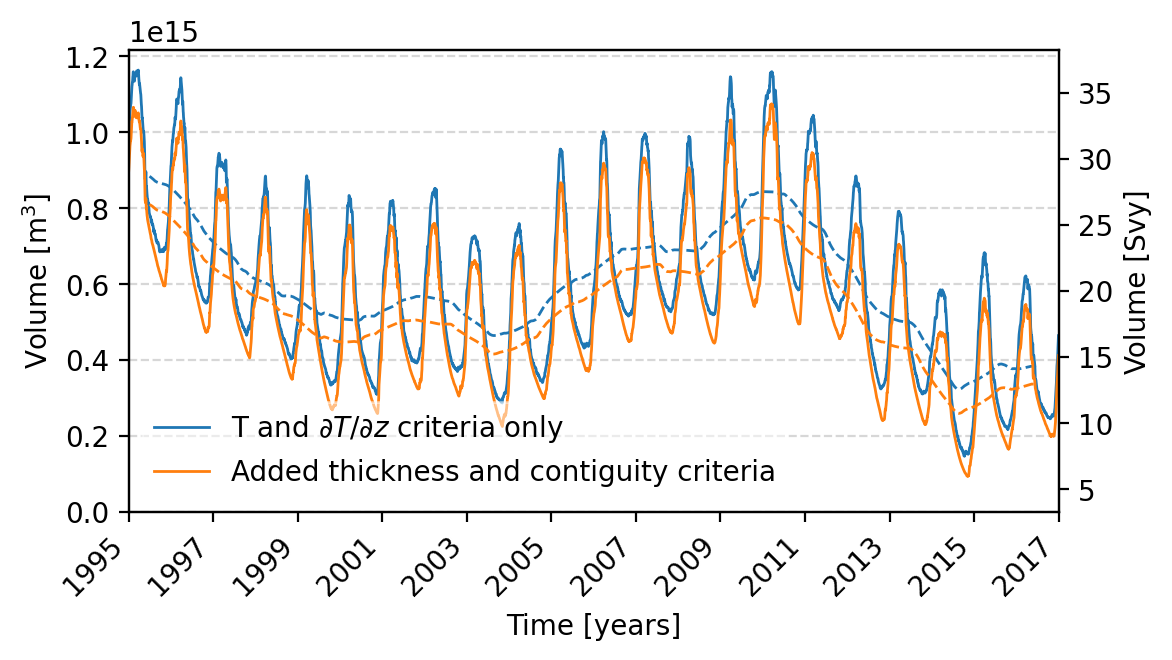

In [23]:
ds_DIC_record.DIC_EDW_EDW_volume

fig, ax = plt.subplots(figsize=(6, 3))
# (ds_DIC_record.DIC_EDW_EDW_volume).plot(ax=ax, linewidth=0.5, label=r"T and $\partial T/\partial z$ criteria")
ds_DIC_record.DIC_EDW_EDW_volume.plot(ax=ax, linewidth=1, label=r"T and $\partial T/\partial z$ criteria only")
(ds_DIC_record.DIC_EDW_EDW_volume.rolling(time=365).mean(skipna=True).shift(time=-365//2)).plot(ax=ax, color="C0", linestyle="--", linewidth=1)

# (ds_DIC_record.DIC_EDW_EDW_volume_incl_thickness_blobs).plot(ax=ax, color='C1', label="Strict criteria")
ds_DIC_record.DIC_EDW_EDW_volume_incl_thickness_blobs.plot(ax=ax, color='C1', linewidth=1, label="Added thickness and contiguity criteria")
(ds_DIC_record.DIC_EDW_EDW_volume_incl_thickness_blobs.rolling(time=365).mean(skipna=True).shift(time=-365//2)).plot(ax=ax, color='C1', linestyle='--', linewidth=1)


ax.set_xticks([np.datetime64(f'{1995 + i*2}-01-01') for i in range(14)])
ax.set_xticklabels(labels=[1995+i*2 for i in range(14)], rotation=45)
ax.set_xlim([ds_DIC_record.time[0], ds_DIC_record.time[-1]+np.timedelta64(1, 'D')])
# ax.set_title("Modeled NASTMW volume")
ax.set_ylabel("Volume [m$^3$]")
ax.set_ylim(0, None)
ax.set_xlabel("Time [years]")
ax.legend(fancybox=False, edgecolor='white', framealpha=0.5)
ax.grid(linestyle='--', alpha=0.5, axis='y', which='both')
ax2 = ax.twinx()
(ds_DIC_record.DIC_EDW_EDW_volume.rolling(time=30).mean(skipna=True) / (1e6 * 365 * 24 * 60 * 60)).plot(ax=ax2, linewidth=0)

ax2.set_ylabel("Volume [Svy]")
plt.savefig("figures/NASTMW_volume.pdf", bbox_inches="tight")

In [65]:
yearly_maximum = ds_DIC_record.DIC_EDW_EDW_volume.groupby('time.year').max(dim='time')
yearly_minimum = ds_DIC_record.DIC_EDW_EDW_volume.groupby('time.year').min(dim='time')
yearly_production = yearly_maximum - yearly_minimum

print(f"Maximum volume: {float(yearly_maximum.mean().values):.2e} m³")
print(f"Minimum volume: {float(yearly_minimum.mean().values):.2e} m³")
print(f"Production: {float(yearly_production.mean().values):.2e} m³")

Maximum volume: 9.03e+14 m³
Minimum volume: 4.13e+14 m³
Production: 4.90e+14 m³


In [66]:
# from batesMultidecadalUptakeCarbon2012
STMW_vol_bates = 75 * 1e6 * 365 * 24 * 60 * 60 # 75 svy * 1e6 m^3/sv * 365 d/y * 24 h/d * 60 min/h * 60 s/min; sv = sverdrup = 1e6 m^3/s
print(f"Carbon content in volume would be {STMW_vol_bates * 2100 / 1000 * 12.011 / 10**15} Pg C") # Volume * average DIC concentration [mmol/m^3] * 1000 mmol/mol * 12.011 g/mol / 10^12 g/Pg


Carbon content in volume would be 59.65767612 Pg C


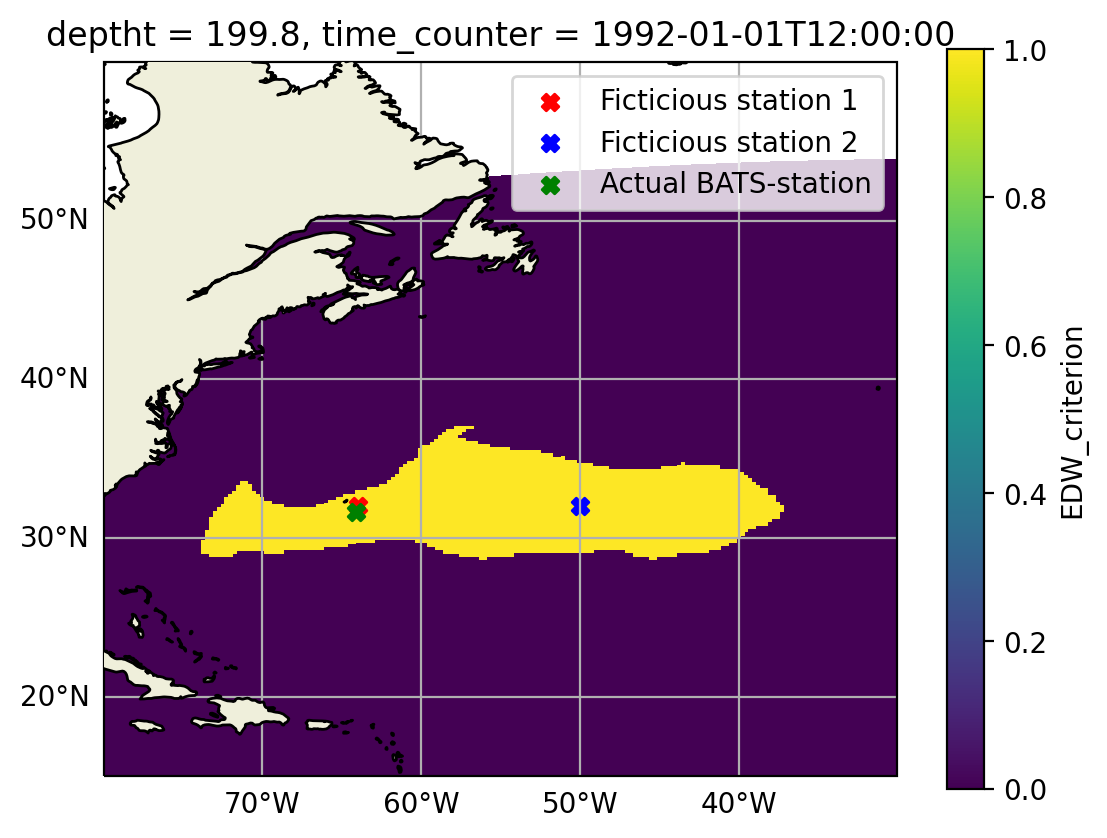

In [67]:
fig = plt.figure()
ax = plt.axes(projection=cart.crs.PlateCarree())
# ax.coastlines()
ax.add_feature(cart.feature.LAND, zorder=100, edgecolor='black')
ax.set_extent([-80, -30, 15, 60], crs=cart.crs.PlateCarree())
dummy_edw.isel(deptht=30).EDW_criterion.plot(ax=ax, x='nav_lon', y='nav_lat', transform=cart.crs.PlateCarree())
ax.scatter(int(xr.open_dataset(DIC_files[0]).nav_lon.isel(x=140, y=137).values),
           int(xr.open_dataset(DIC_files[0]).nav_lat.isel(x=140, y=137).values),
           marker='X', color='red', transform=cart.crs.PlateCarree(),
           label="Ficticious station 1")
ax.scatter(int(xr.open_dataset(DIC_files[0]).nav_lon.isel(x=199, y=136).values),
           int(xr.open_dataset(DIC_files[0]).nav_lat.isel(x=199, y=136).values),
           marker='X', color='blue', transform=cart.crs.PlateCarree(), 
           label="Ficticious station 2")
ax.scatter(-64.125, 31.666,
           marker='X', color='green', transform=cart.crs.PlateCarree(), 
           label="Actual BATS-station")
ax.legend()
ax.gridlines(draw_labels=['bottom', 'left'])

Text(0.5, 0.98, 'DIC concentration at station 1')

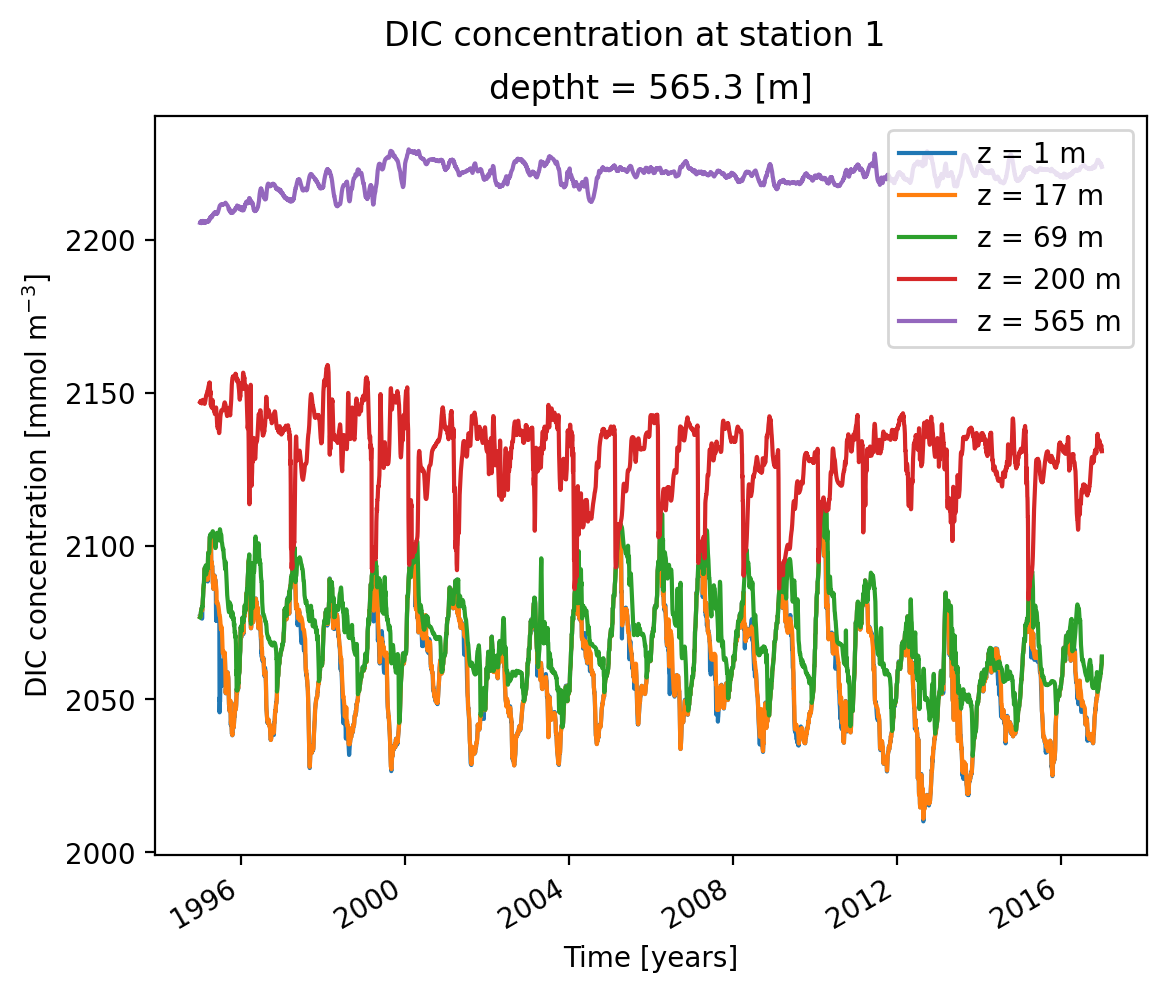

In [68]:
fig, ax = plt.subplots()
ds_DIC_record.DIC_station_1[:,0].plot(ax=ax,label=f"z = {zgrid.gdept_1d[0].values:.0f} m")
ds_DIC_record.DIC_station_1[:,10].plot(ax=ax,label=f"z = {zgrid.gdept_1d[10].values:.0f} m")
ds_DIC_record.DIC_station_1[:,20].plot(ax=ax,label=f"z = {zgrid.gdept_1d[20].values:.0f} m")
ds_DIC_record.DIC_station_1[:,30].plot(ax=ax,label=f"z = {zgrid.gdept_1d[30].values:.0f} m")
ds_DIC_record.DIC_station_1[:,40].plot(ax=ax,label=f"z = {zgrid.gdept_1d[40].values:.0f} m")
ax.legend()
ax.set_xlabel("Time [years]")
ax.set_ylabel("DIC concentration [mmol m$^{-3}$]")
fig.suptitle("DIC concentration at station 1")

Text(0.5, 0.98, 'nDIC concentration at station 1')

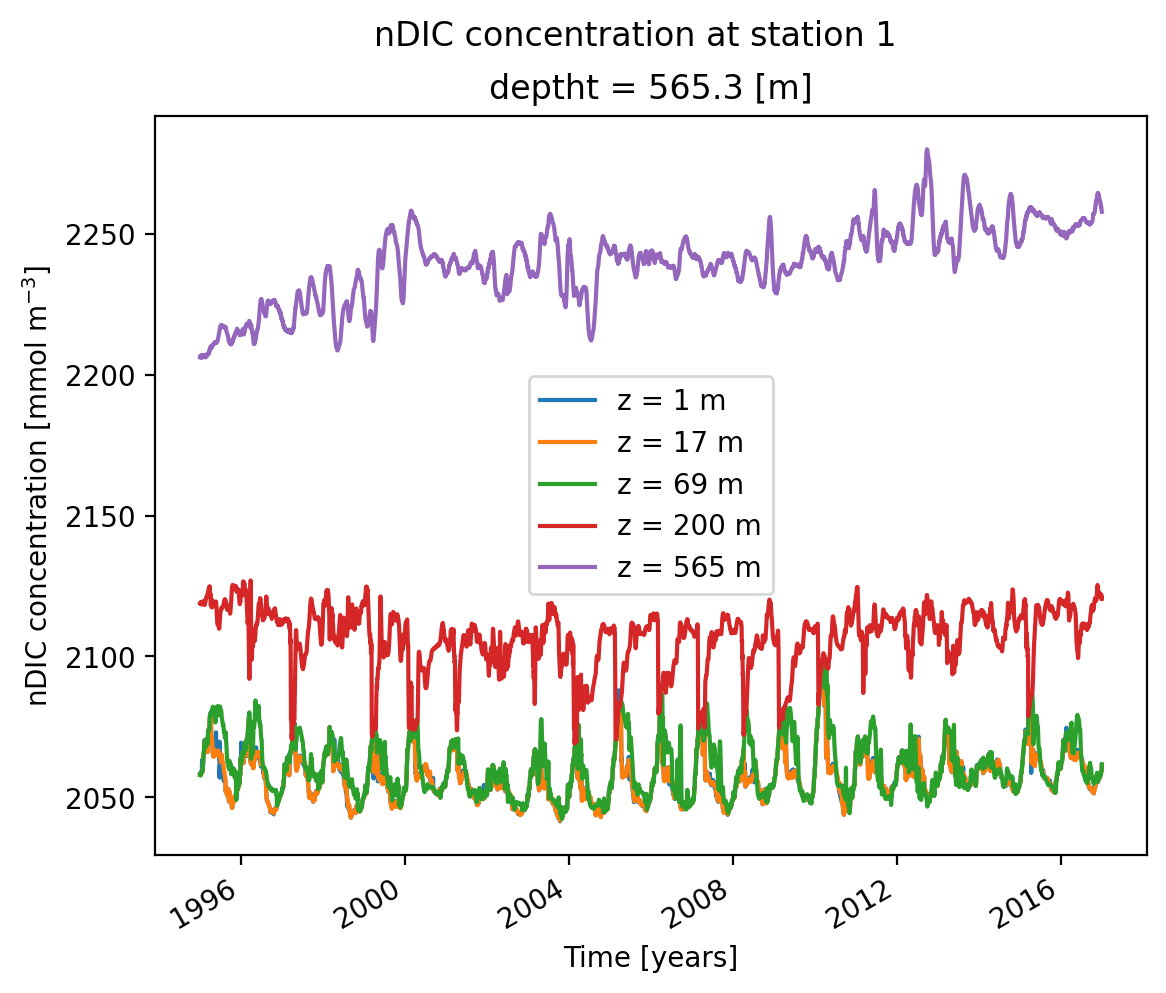

In [69]:
fig, ax = plt.subplots()
(ds_DIC_record.DIC_station_1 / ds_DIC_record.S_station_1 * 36)[:,0].plot(ax=ax,label=f"z = {zgrid.gdept_1d[0].values:.0f} m")
(ds_DIC_record.DIC_station_1 / ds_DIC_record.S_station_1 * 36)[:,10].plot(ax=ax,label=f"z = {zgrid.gdept_1d[10].values:.0f} m")
(ds_DIC_record.DIC_station_1 / ds_DIC_record.S_station_1 * 36)[:,20].plot(ax=ax,label=f"z = {zgrid.gdept_1d[20].values:.0f} m")
(ds_DIC_record.DIC_station_1 / ds_DIC_record.S_station_1 * 36)[:,30].plot(ax=ax,label=f"z = {zgrid.gdept_1d[30].values:.0f} m")
(ds_DIC_record.DIC_station_1 / ds_DIC_record.S_station_1 * 36)[:,40].plot(ax=ax,label=f"z = {zgrid.gdept_1d[40].values:.0f} m")
ax.legend()
ax.set_xlabel("Time [years]")
ax.set_ylabel("nDIC concentration [mmol m$^{-3}$]")
fig.suptitle("nDIC concentration at station 1")

Text(0.5, 0.98, 'DIC concentration at station 2')

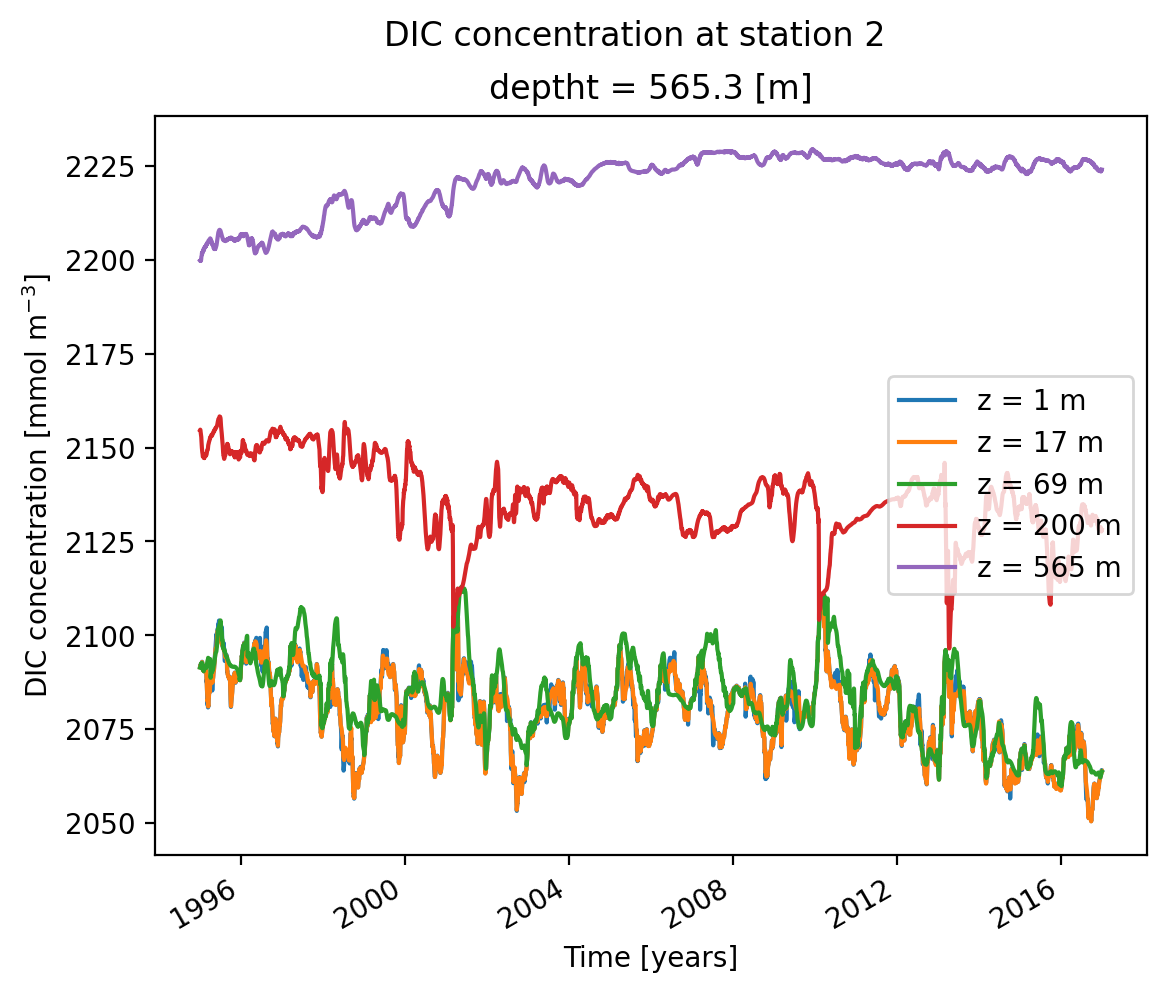

In [70]:
fig, ax = plt.subplots()
ds_DIC_record.DIC_station_2[:,0].plot(ax=ax,label=f"z = {zgrid.gdept_1d[0].values:.0f} m")
ds_DIC_record.DIC_station_2[:,10].plot(ax=ax,label=f"z = {zgrid.gdept_1d[10].values:.0f} m")
ds_DIC_record.DIC_station_2[:,20].plot(ax=ax,label=f"z = {zgrid.gdept_1d[20].values:.0f} m")
ds_DIC_record.DIC_station_2[:,30].plot(ax=ax,label=f"z = {zgrid.gdept_1d[30].values:.0f} m")
ds_DIC_record.DIC_station_2[:,40].plot(ax=ax,label=f"z = {zgrid.gdept_1d[40].values:.0f} m")
ax.legend()
ax.set_xlabel("Time [years]")
ax.set_ylabel("DIC concentration [mmol m$^{-3}$]")
fig.suptitle("DIC concentration at station 2")

Text(0.5, 0.98, 'DIC concentration at station 2')

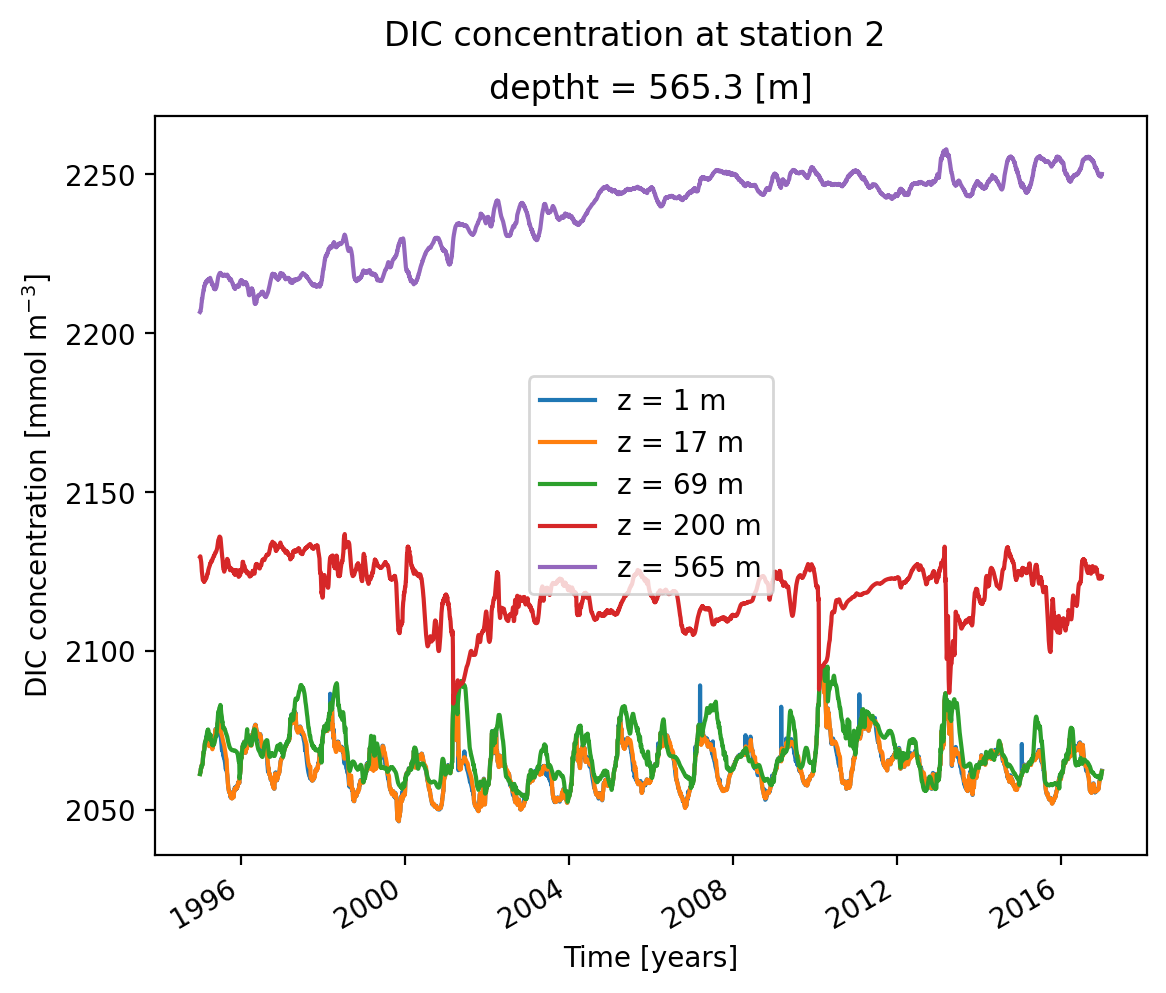

In [71]:
fig, ax = plt.subplots()
(ds_DIC_record.DIC_station_2 / ds_DIC_record.S_station_2 * 36)[:,0].plot(ax=ax,label=f"z = {zgrid.gdept_1d[0].values:.0f} m")
(ds_DIC_record.DIC_station_2 / ds_DIC_record.S_station_2 * 36)[:,10].plot(ax=ax,label=f"z = {zgrid.gdept_1d[10].values:.0f} m")
(ds_DIC_record.DIC_station_2 / ds_DIC_record.S_station_2 * 36)[:,20].plot(ax=ax,label=f"z = {zgrid.gdept_1d[20].values:.0f} m")
(ds_DIC_record.DIC_station_2 / ds_DIC_record.S_station_2 * 36)[:,30].plot(ax=ax,label=f"z = {zgrid.gdept_1d[30].values:.0f} m")
(ds_DIC_record.DIC_station_2 / ds_DIC_record.S_station_2 * 36)[:,40].plot(ax=ax,label=f"z = {zgrid.gdept_1d[40].values:.0f} m")
ax.legend()
ax.set_xlabel("Time [years]")
ax.set_ylabel("DIC concentration [mmol m$^{-3}$]")
fig.suptitle("DIC concentration at station 2")

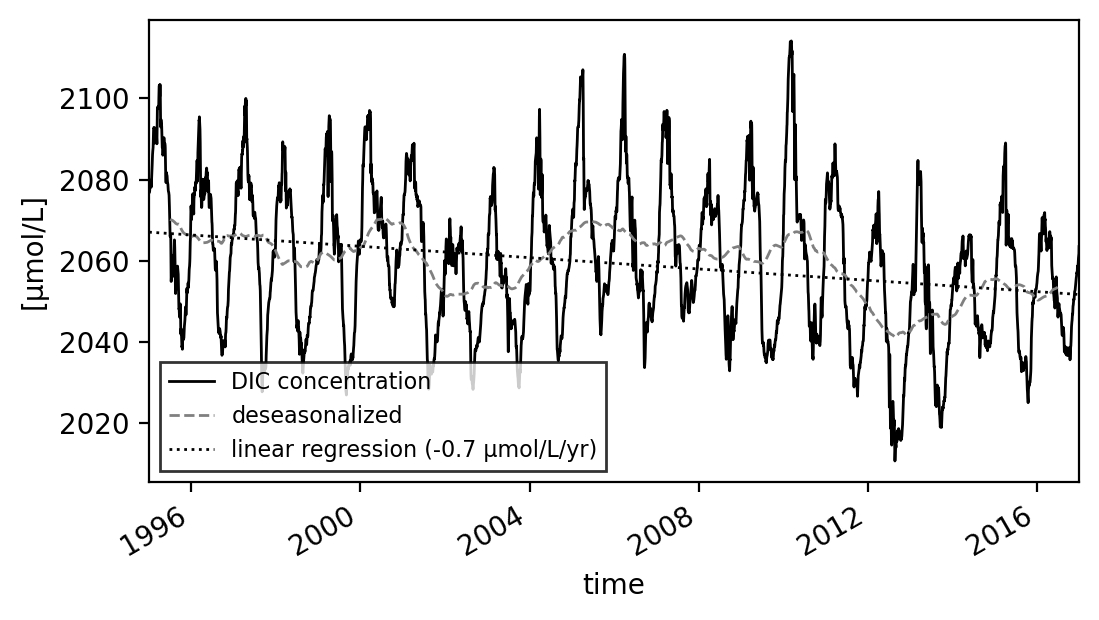

In [84]:
import statsmodels.api as sm
from scipy.stats import linregress

record = ds_DIC_record.DIC_station_1.sel(deptht=10, method='nearest')

fig, ax = plt.subplots(figsize=(6,3))
record.plot(color='black', linewidth=1, label="DIC concentration")

x = np.arange(0, len(record))
y = record.values

decomposition = sm.tsa.seasonal_decompose(y, model='additive', period=365)
trend = decomposition.trend
slope, intercept, r_value, p_value, std_err = linregress(x[~np.isnan(trend)], trend[~np.isnan(trend)])


ax.plot(record.time, trend, color='grey', label='deseasonalized', linestyle='--', linewidth=1)
ax.plot(record.time, intercept + slope*x, color='black', linestyle=':', linewidth=1, label=f"linear regression ({(slope *365):.2} µmol/L/yr)")


ax.set_xlim(record.time[0], record.time[-1])
ax.set_ylabel("[µmol/L]")
ax.set_title(None)
ax.legend(fancybox=False, edgecolor='black', fontsize=8, loc='lower left')

plt.savefig("figures/DIC_station_1.pdf", bbox_inches="tight")


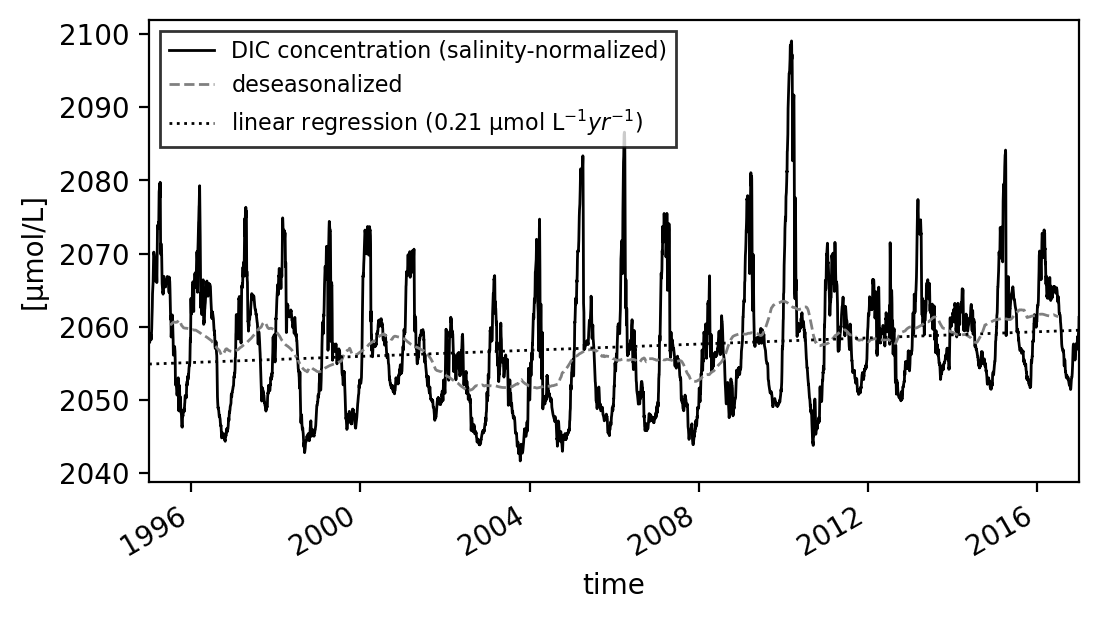

In [19]:
import statsmodels.api as sm
from scipy.stats import linregress

record = (ds_DIC_record.DIC_station_1 / ds_DIC_record.S_station_1 * 36).sel(deptht=10, method='nearest')

fig, ax = plt.subplots(figsize=(6,3))
record.plot(color='black', linewidth=1, label="DIC concentration (salinity-normalized)")

x = np.arange(0, len(record))
y = record.values

decomposition = sm.tsa.seasonal_decompose(y, model='additive', period=365)
trend = decomposition.trend
slope, intercept, r_value, p_value, std_err = linregress(x[~np.isnan(trend)], trend[~np.isnan(trend)])

ax.plot(record.time, trend, color='grey', label='deseasonalized', linestyle='--', linewidth=1)
ax.plot(record.time, intercept + slope*x, color='black', linestyle=':', linewidth=1, label=f"linear regression ({(slope *365):.2} "+r"µmol L$^{-1} yr^{-1}$"+")")


ax.set_xlim(record.time[0], record.time[-1])
ax.set_ylabel("[µmol/L]")
ax.set_title(None)
ax.legend(fancybox=False, edgecolor='black', fontsize=8, loc='upper left')

plt.savefig("figures/DIC_station_1_normalized.pdf", bbox_inches="tight")


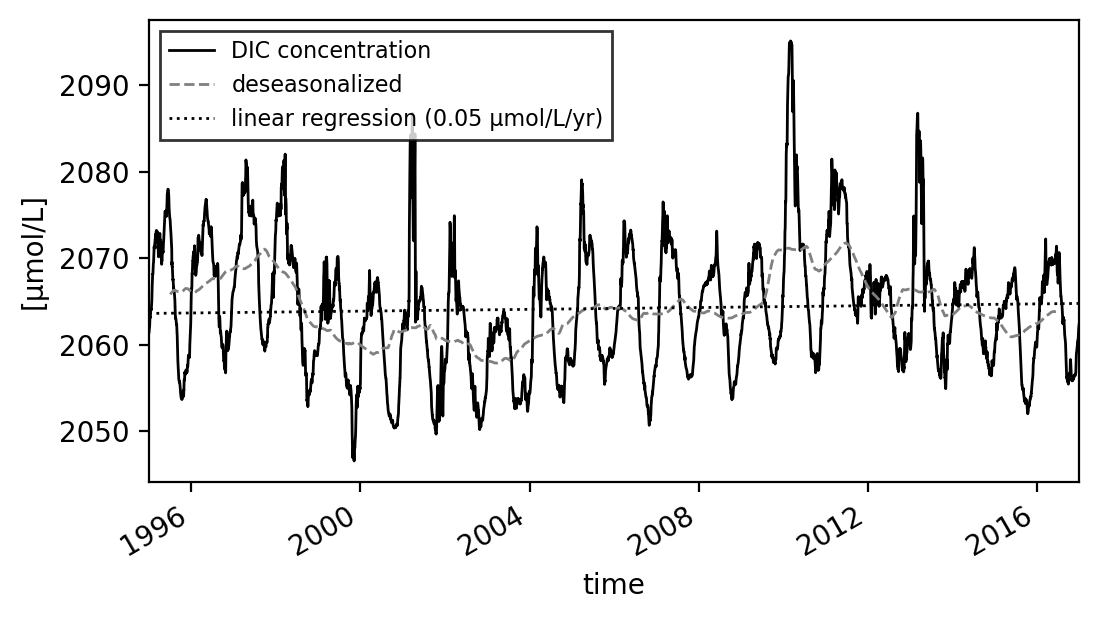

In [18]:
import statsmodels.api as sm
from scipy.stats import linregress

record = (ds_DIC_record.DIC_station_2 / ds_DIC_record.S_station_2 * 36).sel(deptht=10, method='nearest')

fig, ax = plt.subplots(figsize=(6,3))
record.plot(color='black', linewidth=1, label="DIC concentration")

x = np.arange(0, len(record))
y = record.values

decomposition = sm.tsa.seasonal_decompose(y, model='additive', period=365)
trend = decomposition.trend
slope, intercept, r_value, p_value, std_err = linregress(x[~np.isnan(trend)], trend[~np.isnan(trend)])

ax.plot(record.time, trend, color='grey', label='deseasonalized', linestyle='--', linewidth=1)
ax.plot(record.time, intercept + slope*x, color='black', linestyle=':', linewidth=1, label=f"linear regression ({(slope *365):.1} µmol/L/yr)")


ax.set_xlim(record.time[0], record.time[-1])
ax.set_ylabel("[µmol/L]")
ax.set_title(None)
ax.legend(fancybox=False, edgecolor='black', fontsize=8, loc='upper left')

plt.savefig("figures/DIC_station_2_normalized.pdf", bbox_inches="tight")


In [28]:
ds_DIC_record.DIC_station_1[:,10].plot(ax=ax,label=f"z = {zgrid.gdept_1d[10].values:.0f} m")
plt.show()